# an experimental notebook to understand the naive bayes algorithm

# dummy weather example

In [2]:
import math
from collections import defaultdict, Counter

data = [
    ('spam', 'Free money now'),
    ('ham', 'Let’s have lunch tomorrow'),
    ('spam', 'Win big money prizes'),
    ('ham', 'Are we still meeting tomorrow'),
    ('spam', 'Claim your free prize now'),
]

# Step 1: Tokenize and Count
def tokenize(text):
    return text.lower().split()

# Build vocab and count word frequencies
class_counts = Counter()
word_counts = defaultdict(Counter)  # word_counts[class][word]

for label, message in data:
    class_counts[label] += 1
    for word in tokenize(message):
        word_counts[label][word] += 1

# Total words in each class
total_words = {label: sum(words.values()) for label, words in word_counts.items()}
vocab = set(word for words in word_counts.values() for word in words)

# Step 2: Prediction function with Laplace smoothing
def predict(text):
    words = tokenize(text)
    scores = {}
    total_messages = sum(class_counts.values())

    for label in class_counts:
        # Start with log prior
        log_prob = math.log(class_counts[label] / total_messages)
        for word in words:
            # Word likelihood with Laplace smoothing
            word_freq = word_counts[label][word] + 1
            denom = total_words[label] + len(vocab)
            log_prob += math.log(word_freq / denom)
        scores[label] = log_prob

    # Return best label and raw scores
    return max(scores, key=scores.get), scores

test = "Free prize now"
label, score = predict(test)
print(f"Prediction: {label}")
print("Scores:", score)


Prediction: spam
Scores: {'spam': -7.722341355829247, 'ham': -10.690580345938601}


# SMS Naive Bayes

Dataset shape: (5572, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


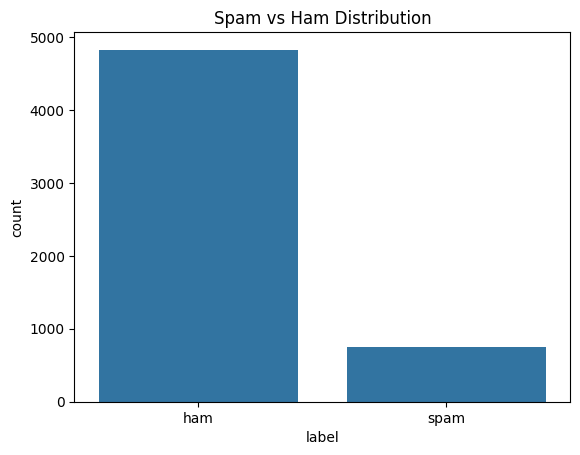

[[1195    7]
 [  17  174]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1202
        spam       0.96      0.91      0.94       191

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393

Top spam words:
           free  ->  log-prob: -4.5220
            txt  ->  log-prob: -4.8369
             ur  ->  log-prob: -5.0367
           stop  ->  log-prob: -5.1272
         mobile  ->  log-prob: -5.1378
           text  ->  log-prob: -5.1813
          claim  ->  log-prob: -5.2038
            www  ->  log-prob: -5.3116
          reply  ->  log-prob: -5.3906
          prize  ->  log-prob: -5.4470
           cash  ->  log-prob: -5.5540
            won  ->  log-prob: -5.5702
           just  ->  log-prob: -5.6557
           send  ->  log-prob: -5.7108
             uk  ->  log-prob: -5.7108
            new  ->  log-prob: -5.7108
      

In [4]:
# 1. Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# 2. Load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'message']

print("Dataset shape:", df.shape)
print(df.head())

# 3. Data distribution
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Distribution")
plt.show()

# 4. Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['message'], df['label'], test_size=0.25, random_state=42
)

# 5. Vectorize using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')  # Removes common English words
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 6. Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# 7. Predict
y_pred = clf.predict(X_test_vec)

# 8. Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 9. BONUS: Look at most "spammy" words
import numpy as np

# Get log probabilities
feature_names = vectorizer.get_feature_names_out()
log_prob_spam = clf.feature_log_prob_[list(clf.classes_).index('spam')]

# Top spam-associated words
top_spam_words = np.argsort(log_prob_spam)[-20:]
print("Top spam words:")
for i in reversed(top_spam_words):
    print(f"{feature_names[i]:>15}  ->  log-prob: {log_prob_spam[i]:.4f}")


## ROC Curve

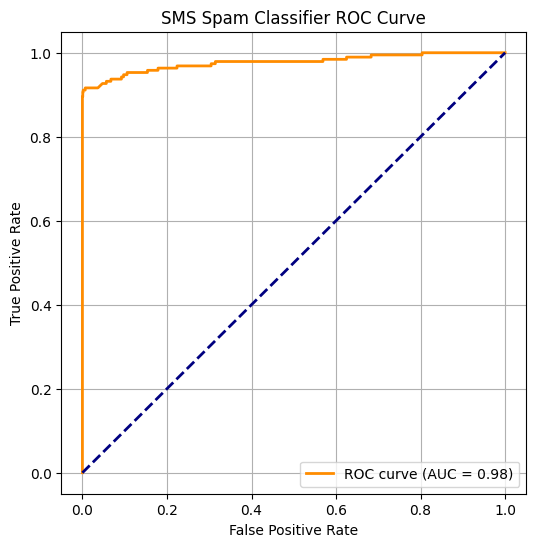

In [5]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class ('spam')
y_proba = clf.predict_proba(X_test_vec)[:, list(clf.classes_).index('spam')]

# Binarize labels: 'spam' = 1, 'ham' = 0
y_test_binary = (y_test == 'spam').astype(int)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SMS Spam Classifier ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Email CSV Naive Bayes

In [8]:
# 1. Load dataset
df_email = pd.read_csv('emails.csv')  # rename if needed
df_email.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


Index(['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou'], dtype='object')
Prediction
0    3672
1    1500
Name: count, dtype: int64
[[862  51]
 [ 18 362]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       913
           1       0.88      0.95      0.91       380

    accuracy                           0.95      1293
   macro avg       0.93      0.95      0.94      1293
weighted avg       0.95      0.95      0.95      1293



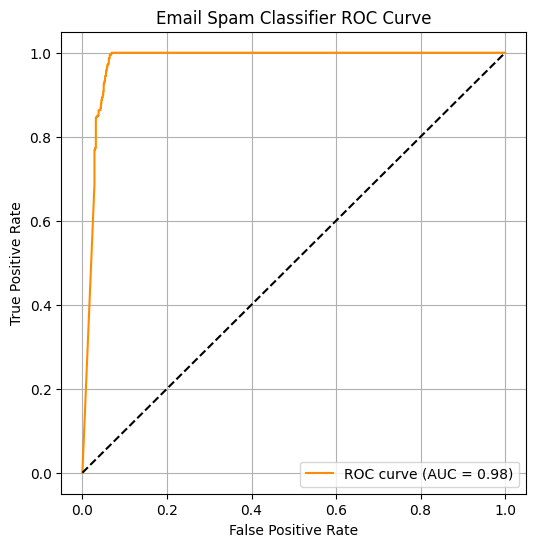

In [12]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('emails.csv')

# Check structure
print(df.columns[:10])  # Should start with: 'Email No.', 'the', 'to', ...
print(df['Prediction'].value_counts())  # Check label distribution

# Drop non-feature columns
X = df.drop(columns=['Email No.', 'Prediction'])  # features = all word counts
y = df['Prediction']  # target = spam or ham (1 or 0)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Train
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability of spam

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Email Spam Classifier ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
